The notebook demonstrates how to solve a damping harmonic oscillator system. 
\begin{align}
\ddot{x} + 2 \zeta \omega_0 \dot{x} + \omega_0^2  x = f
\end{align}

In [1]:
import numpy  as np
import pandas as pd
import ode    as odeLib        # our ODE routines
import matplotlib.pyplot as plt
from   scipy import integrate

Method 1: solve the ODE system with self-defined Euler, Midpoint, and Runge-Kutta methods. The ODE solvers are defined in ode.py that comes along with this repository.

In [2]:
#
# define probelm
#
class parameters:                 # parameters for functions, default values
    zeta    = 0.1
    omega0  = 2.*np.pi*1.0

# 
# define functions for ODE solvres, need to be in f(t,x,par) format
#
# damping harmonic oscillator, dx/dt for dotx and x.

ndim   = 2
vlabel = ["x", "dotx"]            # labels for the variables
def f0(t,x,par):                  # dx/dt      = dotx
    return x[1]
def f1(t,x,par):                  # d(dotx)/dt = f - 2*zeta*omega0*dotx - omega0^2*x 
    return -2.*zeta*omega0*x[1] - omega0**2*x[0]
def ode_solver(time, xInit, method, ndim, par):
    # method supports three options
    # - 'eular'
    # - 'midpoint'
    # - 'runge_kutta'
    
    nstep = len(time)
    xout  = np.empty((nstep,ndim))
    
    hs    = time[1] - time[0]
    xtmp  = xInit
    f     = [f0, f1]
    for i, t in enumerate(time):
        xout[i][:] = xtmp
        if method  == 'euler':
            xtmp   = odeLib.euler(t,xtmp,f,ndim,hs,par)
        elif method == 'midpoint':
            xtmp   = odeLib.midpoint(t,xtmp,f,ndim,hs,par)
        elif method == 'runge_kutta':
            xtmp   = odeLib.runge_kutta(t,xtmp,f,ndim,hs,par)
    return xout[:, 0]

Method 2: solve the ODE system with finite difference.

In [3]:
# Finite difference.
# Central difference for the first derivative.
def fd(t, zeta, omega0, x0, xdot0, x_1):
    # t is discretized time series.
    # zeta, omega0 are constants in the equations.
    # x0 and x_1 are boundary conditions x[0] and x[-1].
    # xdot0 is {dx/dt}[0], initial condition.
    
    # x''= [x(n+1)-2x(n)+x(n-1)]/dt^2
    # x' = (x(n+1)-x(n-1))/dt/2
    # the ODE is discretized into
    # [x(n+1)-2x(n)+x(n-1)]/dt^2 + 2*zeta*omega0*(x(n+1)-x(n-1))/dt/2 + omega^2*x(n) = f(x(n)) + delta(dt^2)
    
    x    = np.zeros_like(t)
    x[0] = x0
    dt   = t[1] - t[0]
    x[1] = xdot0*dt*2 + x_1 
    # print(x[0], x[1])
    a1   = zeta*omega0*dt
    a2   = omega0**2*dt**2
    for i in range(2,len(t)):
        x[i] = (2.-a2)*x[i-1] + (a1-1.)*x[i-2]
        x[i] = x[i]/(1.+a1)
        # print(i,x[i],a1,a2,dt)
    return x
    

Method 3: sovle the ODE system with the ODE solver in Scipy integrate. 

In [4]:
def odeF(X, t, zeta, omega0):
    """
    Free Harmonic Oscillator ODE
    """
    x, dotx = X
    ddotx = -2*zeta*omega0*dotx - omega0**2*x
    return [dotx, ddotx]

def ode_solver_scipy(xInit, zeta = 0.05, omega0 = 2.*np.pi):
    sol     = integrate.odeint(odeF, xInit, t, args = (zeta, omega0))
    return sol[:, 0]


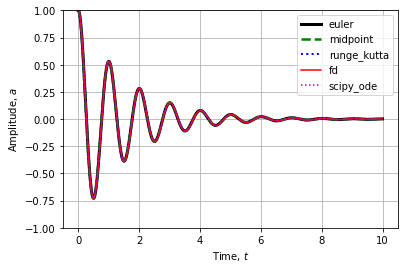

In [5]:
Nt     = 1000
t      = np.linspace(0., 10., Nt)

# initial and boundary conditions for the finite difference method.
x0     = 1.
x_1    = 1. # Assume x[-1] = x[0]
xdot0  = 0.

# 
xInit  = [1., 0.] # x[0] and dotx[0]

# set constants for the system
omega0 = 2.*np.pi*1.
zeta   = 0.1

par        = parameters()
par.zeta   = zeta
par.omega0 = omega0

# Method 1, Euler.
xInit  = [1., 0.] # x[0] and dotx[0]
x1a    = ode_solver(t, xInit, 'euler',       ndim, par)

# Method 1, Midpoint
xInit  = [1., 0.] # x[0] and dotx[0]
x1b    = ode_solver(t, xInit, 'midpoint',    ndim, par)

# Method 1, Runge_Kutta
xInit  = [1., 0.] # x[0] and dotx[0]
x1c    = ode_solver(t, xInit, 'runge_kutta', ndim, par)

# Method 2, FD
x2     = fd(t, zeta, omega0, x0, xdot0, x_1) # Method 2, fd

# Method 3, Scipy ODE.
xInit  = [1., 0.] # x[0] and dotx[0]
x3     = ode_solver_scipy(xInit, zeta, omega0) # Method 3, scipy

fig    = plt.figure()

plt.plot(t, x1a, 'k',    label='euler',       linewidth=3)
plt.plot(t, x1b, 'g--',  label='midpoint',    linewidth=2.5)
plt.plot(t, x1c, 'b:',   label='runge_kutta', linewidth=2)
plt.plot(t, x2,  'r-',   label='fd')
plt.plot(t, x3,  'm:',   label='scipy_ode')

plt.grid()
plt.ylim(-1., 1.)
plt.xlabel("Time, $t$")
plt.ylabel("Amplitude, $a$")
plt.legend()